## In this notebook

- Get models predictions and create data for submission.

In [1]:
import os
import shutil
import datetime

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# model
from tensorflow import keras
from keras.models import load_model

# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: cannot open shared object file: No such file or directory']
  warnings.warn(f"file system plugin

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
DATA_FOLDER = "../data"

TIMESTEP = 96
TEST_DATA_DAYS_CNT = 19
TEST_DATA_MIN_DATE = "2021-02-19 00:00:00"
TEST_DATA_MAX_DATE = "2021-03-10 23:45:00"

TARGETS = ["Available", "Charging", "Passive", "Other"]
SUBMISSIONS_FOLDER = "../data/submissions/"

In [4]:
! ls -l $DATA_FOLDER

total 182060
-rw-r--r-- 1 nobody nogroup    570468 Nov 28 10:44 20221128104433_submissions.zip
drwxr-xr-x 5 nobody nogroup       160 Nov 28 10:06 submissions
-rw-rw-r-- 1 nobody nogroup  14095077 Aug  4 08:41 test.csv
-rw-rw-r-- 1 nobody nogroup 171754453 Aug  4 08:41 train.csv


## Load data

In [5]:
# load train data

df = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
df.columns = [col.lower() for col in df.columns]
df = df.sort_values(by="date").reset_index(drop=True)

df.tail()

,date,station,available,charging,passive,other,tod,dow,trend,latitude,longitude,postcode,area
1851078,2021-02-18 23:45:00,FR*V75*EBELI*32*1,3,0,0,0,95,5,22202,48.84477,2.352420,75005,south
1851079,2021-02-18 23:45:00,FR*V75*EBELI*31*1,2,1,0,0,95,5,22202,48.85104,2.345493,75005,south
1851080,2021-02-18 23:45:00,FR*V75*EBELI*30*1,2,0,1,0,95,5,22202,48.84571,2.345032,75005,south
1851081,2021-02-18 23:45:00,FR*V75*EBELI*39*1,1,0,1,1,95,5,22202,48.85267,2.313680,75007,west
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,0,0,0,95,5,22202,48.87780,2.391820,75019,east


## Get predictions

### 1st option

- Prediction one by one.
- Very slow, but seems to be more precise.

In [6]:
%%time

"""
preds = []

for y_column in ["available", "charging", "passive"]:
    
    model = load_model(f"./models/col_{y_column}_1.h5")

    for station in df.station.unique():

        last_values = (
            df
            .loc[df.station == station, y_column]
            .tail(TIMESTEP)
            .astype(float)
            .to_list()
        )
        
        for i, date in enumerate(pd.date_range(start=TEST_DATA_MIN_DATE, end=TEST_DATA_MAX_DATE, freq="15min")):
            if i > 0:
                last_values.pop(0)
                last_values.append(pred)

            pred = model.predict(
                np.array(last_values).reshape(1, TIMESTEP, 1), 
                verbose=0
            )[0][0][0]
            
            preds.append({
                "date": date,
                "station": station,
                f"{y_column}": pred,
            })
        
        print(f"✅ Finished predicting the following station: {station}")
        
        break
    
    break
    
df_preds = pd.DataFrame(preds)
df_preds.shape
"""

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


'\npreds = []\n\nfor y_column in ["available", "charging", "passive"]:\n    \n    model = load_model(f"./models/col_{y_column}_1.h5")\n\n    for station in df.station.unique():\n\n        last_values = (\n            df\n            .loc[df.station == station, y_column]\n            .tail(TIMESTEP)\n            .astype(float)\n            .to_list()\n        )\n        \n        for i, date in enumerate(pd.date_range(start=TEST_DATA_MIN_DATE, end=TEST_DATA_MAX_DATE, freq="15min")):\n            if i > 0:\n                last_values.pop(0)\n                last_values.append(pred)\n\n            pred = model.predict(\n                np.array(last_values).reshape(1, TIMESTEP, 1), \n                verbose=0\n            )[0][0][0]\n            \n            preds.append({\n                "date": date,\n                "station": station,\n                f"{y_column}": pred,\n            })\n        \n        print(f"✅ Finished predicting the following station: {station}")\n        \n

In [7]:
"""
ax = df_preds.available.plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs prediction")
ax.set_title(f"Predictions")

plt.show()
"""

'\nax = df_preds.available.plot()\n\nax.set_xlabel("Timeline")\nax.set_ylabel("Available plugs prediction")\nax.set_title(f"Predictions")\n\nplt.show()\n'

### 2nd option

- Prediction daily batches.
- Much faster, but seems to be less precise.

In [8]:
%%time

dfs = []

for y_column in ["available", "charging", "passive"]:
    
    model = load_model(f"./models/col_{y_column}_1.h5")
    
    for station in df.station.unique():
        
        preds = []
        last_values = (
            df
            .loc[df.station == station, y_column]
            .tail(TIMESTEP)
            .astype(float)
            .to_list()
        )
        
        for i in enumerate(range(20)):
            last_values = model.predict(
                np.array(last_values).reshape(1, TIMESTEP, 1), 
                verbose=0
            )
            
            preds += last_values.reshape(-1).tolist()
        
        dfs.append(
            pd.DataFrame({
                "date": pd.date_range(start=TEST_DATA_MIN_DATE, end=TEST_DATA_MAX_DATE, freq="15min"),
                "station": station,
                f"{y_column}": preds,
            })
        )

    print(f"✅ Finished predicting `{y_column}` column.")

✅ Finished predicting `available` column.
✅ Finished predicting `charging` column.
✅ Finished predicting `passive` column.
CPU times: user 3min 12s, sys: 8.88 s, total: 3min 21s
Wall time: 2min 48s


In [17]:
df_preds = pd.concat(dfs, ignore_index=True)
df_preds.tail()

,date,station,available,charging,passive
524155,2021-03-10 22:45:00,FR*V75*EBELI*4*1,NaN,NaN,0.225760
524156,2021-03-10 23:00:00,FR*V75*EBELI*4*1,NaN,NaN,0.225014
524157,2021-03-10 23:15:00,FR*V75*EBELI*4*1,NaN,NaN,0.223979
524158,2021-03-10 23:30:00,FR*V75*EBELI*4*1,NaN,NaN,0.222371
524159,2021-03-10 23:45:00,FR*V75*EBELI*4*1,NaN,NaN,0.223171


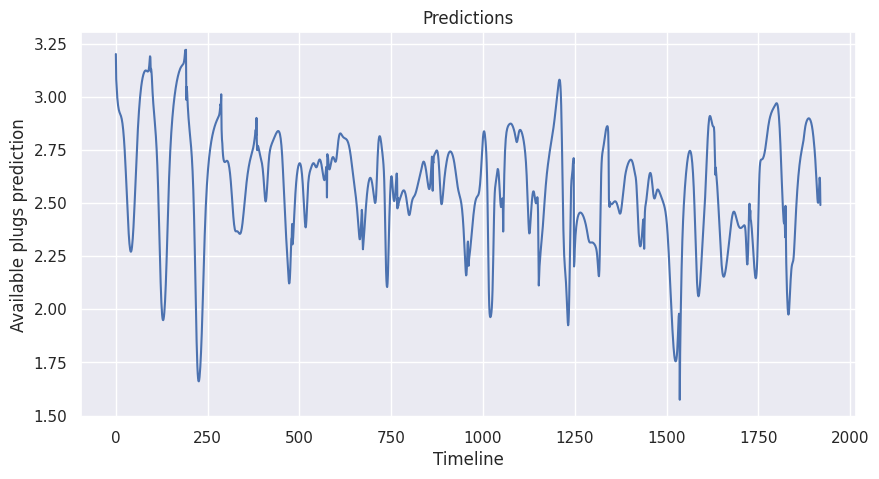

In [18]:
ax = (
    df_preds
    .head(1920)
    .available
    .plot()
)

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs prediction")
ax.set_title(f"Predictions")

plt.show()

## Process predictions

In [19]:
# put the predicted values on one row

df_available = df_preds.loc[~df_preds.available.isna(), ["date", "station", "available"]]
df_charging = df_preds.loc[~df_preds.charging.isna(), ["date", "station", "charging"]]
df_passive = df_preds.loc[~df_preds.passive.isna(), ["date", "station", "passive"]]

assert len(df_available) == len(df_charging) == len(df_passive)

df_preds = (
    df_available
    .merge(df_charging)
    .merge(df_passive)
)

df_preds.loc[:, ["available", "charging", "passive"]] = (
    df_preds
    .loc[:, ["available", "charging", "passive"]]
    .clip(lower=0, upper=3)
    .round()
    .astype(int)
)

df_preds["other"] = 0
df_preds.tail()

/tmp/ipykernel_10/312461518.py:15: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_preds.loc[:, ["available", "charging", "passive"]] = (


,date,station,available,charging,passive,other
174715,2021-03-10 22:45:00,FR*V75*EBELI*4*1,3,0,0,0
174716,2021-03-10 23:00:00,FR*V75*EBELI*4*1,3,0,0,0
174717,2021-03-10 23:15:00,FR*V75*EBELI*4*1,3,0,0,0
174718,2021-03-10 23:30:00,FR*V75*EBELI*4*1,3,0,0,0
174719,2021-03-10 23:45:00,FR*V75*EBELI*4*1,3,0,0,0


In [20]:
# get plugs sum

df_preds["plugs_sum"] = (
    df_preds
    .loc[:, ["available", "charging", "passive", "other"]]
    .sum(axis=1)
)

df_preds.plugs_sum.value_counts()

3    97952
2    41199
4    31764
1     2061
5     1500
0      199
6       45
Name: plugs_sum, dtype: int64

In [21]:
# add other column values

df_preds["other"] = (
    df_preds
    .other
    .where(
        df_preds.plugs_sum.ge(3),
        df_preds.plugs_sum.mul(-1).add(3)
    )
)

In [22]:
# get rid of plugs_sum == 4 

# check distributions
(
    df_preds
    .loc[df_preds.plugs_sum == 4]
    .apply(
        lambda row: f"{int(row['available'])}-{int(row['charging'])}-{int(row['passive'])}",
        axis=1
    )
    .value_counts()
)

3-1-0    30206
2-2-0      632
3-0-1      588
2-0-2      194
2-1-1      144
dtype: int64

In [23]:
# believe the most in `available` column model

def get_rid_of_plugs_sum_4_charging(row: dict):
    plugs_sum = row["plugs_sum"]
    available = row["available"]
    charging = row["charging"]
    
    if plugs_sum != 4:
        return charging
    
    if available == 3:
        return 0
    
    if available == 2 and charging == 2:
        return 1
    
    return charging
    
def get_rid_of_plugs_sum_4_passive(row: dict):
    plugs_sum = row["plugs_sum"]
    available = row["available"]
    charging = row["charging"]
    passive = row["passive"]
    
    if plugs_sum != 4:
        return passive
    
    if available == 3:
        return 0
    
    if available == 2 and passive == 2:
        return 1
    
    if available == 2 and charging == 1:
        return 0
    
    return passive

df_preds["charging"] = df_preds.apply(lambda row: get_rid_of_plugs_sum_4_charging(row), axis=1)
df_preds["passive"] = df_preds.apply(lambda row: get_rid_of_plugs_sum_4_passive(row), axis=1)

In [24]:
# get plugs sum

df_preds["plugs_sum"] = (
    df_preds
    .loc[:, ["available", "charging", "passive", "other"]]
    .sum(axis=1)
)

df_preds.plugs_sum.value_counts()

3    173175
5      1500
6        45
Name: plugs_sum, dtype: int64

In [25]:
# get rid of plugs_sum == 5 

# check distributions
(
    df_preds
    .loc[df_preds.plugs_sum == 5]
    .apply(
        lambda row: f"{int(row['available'])}-{int(row['charging'])}-{int(row['passive'])}",
        axis=1
    )
    .value_counts()
)

3-2-0    1221
3-0-2     148
3-1-1     113
2-1-2      12
2-3-0       6
dtype: int64

In [26]:
# believe the most in `available` column model

def get_rid_of_plugs_sum_5_charging(row: dict):
    plugs_sum = row["plugs_sum"]
    available = row["available"]
    charging = row["charging"]
    
    if plugs_sum != 5:
        return charging
    
    if available == 3:
        return 0
    
    if available == 2 and charging == 3:
        return 1
    
    return charging
    
def get_rid_of_plugs_sum_5_passive(row: dict):
    plugs_sum = row["plugs_sum"]
    available = row["available"]
    charging = row["charging"]
    passive = row["passive"]
    
    if plugs_sum != 5:
        return passive
    
    if available == 3:
        return 0
    
    if available == 2 and charging == 1:
        return 0
    
    return passive

df_preds["charging"] = df_preds.apply(lambda row: get_rid_of_plugs_sum_5_charging(row), axis=1)
df_preds["passive"] = df_preds.apply(lambda row: get_rid_of_plugs_sum_5_passive(row), axis=1)

In [27]:
# get plugs sum

df_preds["plugs_sum"] = (
    df_preds
    .loc[:, ["available", "charging", "passive", "other"]]
    .sum(axis=1)
)

df_preds.plugs_sum.value_counts()

3    174675
6        45
Name: plugs_sum, dtype: int64

In [28]:
# get rid of plugs_sum == 6

# check distributions
(
    df_preds
    .loc[df_preds.plugs_sum == 6]
    .apply(
        lambda row: f"{int(row['available'])}-{int(row['charging'])}-{int(row['passive'])}",
        axis=1
    )
    .value_counts()
)

3-1-2    28
3-2-1    10
3-3-0     7
dtype: int64

In [29]:
df_preds.loc[df_preds.plugs_sum == 6, "charging"] = 0
df_preds.loc[df_preds.plugs_sum == 6, "passive"] = 0

In [30]:
# get plugs sum

df_preds["plugs_sum"] = (
    df_preds
    .loc[:, ["available", "charging", "passive", "other"]]
    .sum(axis=1)
)

df_preds.plugs_sum.value_counts()

3    174720
Name: plugs_sum, dtype: int64

## Create submission

In [31]:
df_test = pd.read_csv(os.path.join(DATA_FOLDER, "test.csv"))
df_test.tail()

,date,Station,tod,dow,trend,Latitude,Longitude,Postcode,area
165979,2021-03-10 23:45:00,FR*V75*EBELI*95*1,95,4,24122,48.86851,2.295469,75016,west
165980,2021-03-10 23:45:00,FR*V75*EBELI*96*1,95,4,24122,48.83550,2.349650,75013,south
165981,2021-03-10 23:45:00,FR*V75*EBELI*97*1,95,4,24122,48.83995,2.397822,75012,east
165982,2021-03-10 23:45:00,FR*V75*EBELI*98*1,95,4,24122,48.84998,2.361920,75004,south
165983,2021-03-10 23:45:00,FR*V75*EBELI*99*1,95,4,24122,48.87780,2.391820,75019,east


In [32]:
# join preds on test data

df_preds["date"] = df_preds.date.astype(str)

df_test = (
    df_test
    .merge(
        df_preds, 
        how="left",
        left_on=["date", "Station"],
        right_on=["date", "station"],
    )
    .rename(
        {
            "available": "Available", 
            "charging": "Charging", 
            "passive": "Passive", 
            "other": "Other",
        }, 
        axis=1
    )
    .drop(["station", "plugs_sum"], axis=1)
)

df_test.tail()

,date,Station,tod,dow,trend,Latitude,Longitude,Postcode,area,Available,Charging,Passive,Other
165979,2021-03-10 23:45:00,FR*V75*EBELI*95*1,95,4,24122,48.86851,2.295469,75016,west,2,0,0,1
165980,2021-03-10 23:45:00,FR*V75*EBELI*96*1,95,4,24122,48.83550,2.349650,75013,south,3,0,0,0
165981,2021-03-10 23:45:00,FR*V75*EBELI*97*1,95,4,24122,48.83995,2.397822,75012,east,2,0,0,1
165982,2021-03-10 23:45:00,FR*V75*EBELI*98*1,95,4,24122,48.84998,2.361920,75004,south,2,0,0,1
165983,2021-03-10 23:45:00,FR*V75*EBELI*99*1,95,4,24122,48.87780,2.391820,75019,east,2,0,0,1


In [33]:
df_test.dtypes

date          object
Station       object
tod            int64
dow            int64
trend          int64
Latitude     float64
Longitude    float64
Postcode       int64
area          object
Available      int64
Charging       int64
Passive        int64
Other          int64
dtype: object

In [34]:
# convert data in the right format

df_test["date"] = pd.to_datetime(df_test["date"])
df_test["Postcode"] = df_test["Postcode"].astype(str)

In [35]:
# create CSV on station level

(
    df_test
    .loc[:, ["date", "area", "Station"] + TARGETS]
    .to_csv(os.path.join(SUBMISSIONS_FOLDER, "station.csv"), index=False)
)

In [36]:
# create CSV on area level

(
    df_test
    .groupby(["date", "area"])[TARGETS]
    .sum()
    .reset_index()
    .to_csv(os.path.join(SUBMISSIONS_FOLDER, "area.csv"), index=False)
)

In [37]:
# create CSV on area level

(
    df_test
    .groupby(["date"])[TARGETS]
    .sum()
    .reset_index()
    .to_csv(os.path.join(SUBMISSIONS_FOLDER, "global.csv"), index=False)
)

In [39]:
# add CSV files into ZIP archive 

dt_now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

shutil.make_archive(
    base_name=f"/usr/src/app/data/{dt_now}_submissions", 
    format="zip", 
    root_dir="/usr/src/app/data/submissions/"
)

'/usr/src/app/data/20221128141653_submissions.zip'

## Results

- Predictions have been found, and submission files were created.